# Initialisations

In [1]:
import pandas as pd ; pd.set_option('display.max_columns', 500)
import numpy as np
import ipywidgets as widgets

from sklearn.model_selection import train_test_split

from sklearn import ensemble #gradientboosting
from sklearn import linear_model #lasso
from sklearn import tree #decision tree

from sklearn.metrics import mean_absolute_error
import joblib
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

# below imports add mpld3 functionality
# hover-over labels for plots
#import mpld3
#mpld3.enable_notebook()

train_scores = dict() ; test_scores  = dict() #to hold scores for viewing at the end

In [119]:
def grid_search_return_hp_dict(model, X_train_gs, y_train_gs, param_grid):
    """Run GridSearchCV on given model with defined param_grid, return best params as dict.
    Pre-assign sklearn model to variable. Pass param_grid as dict."""
    print(str(model).split(sep='(')[0], "grid search.")
    GS = GridSearchCV(model, param_grid, n_jobs=2)
    GS.fit(X_train_gs, y_train_gs)
    print(GS.best_params_)
    return(GS.best_params_)

def produce_exp_vs_pred_df(features_list, model, codename):
    pred_list = []
    for i in range(0, len(X)):
        prediction = model.predict([X[features_list].iloc[i]])
        pred_list.append(prediction)
    train_scores.update({codename : model.score(X_train, y_train)})
    test_scores.update({codename : model.score(X_test, y_test)})
    exp_vs_calc = pd.DataFrame(y)
    exp_vs_calc['Predicted'] = pred_list
    exp_vs_calc.rename({'Kh_first':'Experimental'}, inplace=True, axis=1)
    return exp_vs_calc

def prediction_plot_scores(model_func, pred_df):
    """Print train+test scores, then plot scatter of predicted vs actual HLCs. Uses {X/y}_{train/test},
    redefining these variables will change the output."""
    print('Training Score:\t', model_func.score(X_train, y_train))
    print('Testing Score:\t', model_func.score(X_test, y_test))
    fig = plt.figure(figsize=(10, 10))
    scatter = plt.scatter(pred_df['Experimental'], pred_df['Predicted'])
    plt.xlabel('Experimental')
    plt.ylabel('Predicted')
    plt.title('%s predictions of HLCs' %str(model_func).split(sep='(')[0])
    #abels = ['{}'.format(i) for i in species_names]
    #ooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
    #pld3.plugins.connect(fig, tooltip)
    plt.plot([-30, 10], [-30, 10], c='red')
    plt.show()

# DRAGON descriptors
## Bringing in data and splitting it into parts

In [3]:
csv = pd.read_csv('organics_noVPAS_desc_kh.csv') # contains VP/AS HLCs

print(csv.shape) #input shape

csv.dropna(axis=0, inplace=True)

print(csv.shape) #removed NaN shape

species_names = csv.pop('Unnamed: 0')
smiles_strings = csv.pop('SMILES')
constants_mean = csv.pop('Kh_mean')
constants_first = csv.pop('Kh_first')

varying_columns = csv[['Varying_1', 'Varying_2', 'Varying_3', 'Varying_4',
 'Varying_5', 'Varying_6', 'Varying_7', 'Varying_8', 'Varying_9']] # popping one-hot encoding columns

dragon_features = csv.drop(['Varying_1', 'Varying_2', 'Varying_3', 'Varying_4',
 'Varying_5', 'Varying_6', 'Varying_7', 'Varying_8', 'Varying_9'], axis=1) #seperating features

(1404, 1479)
(1355, 1479)


In [4]:
X = dragon_features ; y = constants_first #renaming to X and y for use in models

## Feature Selection
Made aware of features selection methods in scikitlearn via https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e

See also [scikit-learn docs](https://scikit-learn.org/stable/modules/feature_selection.html)
### Importances via 'dummy' GradientBoostingRegressor

In [79]:
from sklearn.ensemble import GradientBoostingRegressor
fs_model = GradientBoostingRegressor()
fs_model.fit(X, y)
importances = pd.Series(fs_model.feature_importances_, index = X.columns)
top_15_features_model = list(importances.nlargest(15).index.values)

[0.00000000e+00 2.51870139e-07 0.00000000e+00 ... 2.12320632e-04
 0.00000000e+00 8.43543725e-04]


### Importances via 'dummy' LASSO model

In [96]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
dummy_lasso = Lasso(max_iter=10000, alpha=0.5)
selector = SelectFromModel(dummy_lasso).fit(X, y)
coefs = selector.estimator_.coef_
importances_lasso = pd.Series(coefs, index = X.columns)
top_15_lasso = list(importances_lasso.nlargest(15).index.values)

### SelectKBest using f_regression scoring function
F-test estimates degree of linear dependency

In [6]:
from sklearn.feature_selection import SelectKBest, f_regression
fs_kbest = SelectKBest(score_func= f_regression, k=15)
fit = fs_kbest.fit(X, y)
scores_f = pd.Series(fit.scores_, index=X.columns)
top_15_features_kbest = list(scores_f.nlargest(15).index.values)

C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


### SelectKBest using mutual_info_regression
Catch any statistical dependancy, but requires more samples than f_reg

In [7]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression

fs_mut_info = SelectKBest(score_func= mutual_info_regression, k=15)
fit = fs_mut_info.fit(X, y)
scores_mutual = pd.Series(fit.scores_, index=X.columns)
top_15_features_mutual_info = list(scores_mutual.nlargest(15).index.values)

### Feature Selection results

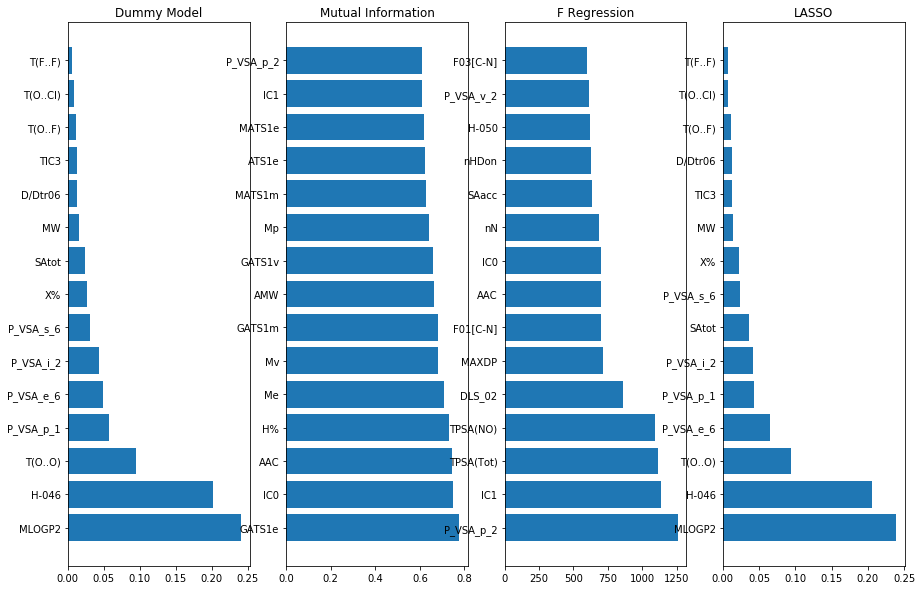

In [85]:
fig, imp_plot = plt.subplots(nrows=1, ncols=4, figsize=(15, 10))
imp_plot[0].barh(importances.nlargest(15).index, importances.nlargest(15))
imp_plot[0].set_title('Dummy Model')
imp_plot[1].barh(scores_mutual.nlargest(15).index, scores_mutual.nlargest(15))
imp_plot[1].set_title('Mutual Information')
imp_plot[2].barh(scores_f.nlargest(15).index, scores_f.nlargest(15))
imp_plot[2].set_title('F Regression')
imp_plot[3].barh(importances_lasso.nlargest(15).index, importances_lasso.nlargest(15))
imp_plot[3].set_title('LASSO')
plt.show()

## GradientBoosting

Grid search completed 20:16 27/12/19 - results: <br>
`{'learning_rate': 0.02, 'loss': 'lad', 'max_depth': 6, 'max_features': 0.3, 'min_samples_leaf': 3, 'n_estimators': 1000}`
### Model-chosen features

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X[top_15_features_model], y, test_size=0.3)

grad_boost_GS = ensemble.GradientBoostingRegressor()

gbr_param_grid = {
    'n_estimators': [500, 1000, 2000],
    'max_depth': [2, 4, 6],
    'min_samples_leaf': [3, 5, 9, 17],
    'learning_rate': [0.1, 0.05, 0.02],
    'max_features': [1.0, 0.3, 0.1],
    'loss': ['ls', 'lad', 'huber']
}

best_hp = grid_search_return_hp_dict(grad_boost_GS, X_train, y_train, gbr_param_grid)
grad_boost = ensemble.GradientBoostingRegressor(**best_hp)
grad_boost.fit(X_train, y_train)

exp_vs_calc_gbr = produce_exp_vs_pred_df(top_15_features_model, grad_boost, "GradBoost, model-chosen features")

GradientBoostingRegressor grid search. 


Hyperparameter ranges:
n_estimators 	 [500, 1000, 2000]
max_depth 	 [2, 4, 6]
min_samples_leaf 	 [3, 5, 9, 17]
learning_rate 	 [0.1, 0.05, 0.02]
max_features 	 [1.0, 0.3, 0.1]
loss 	 ['ls', 'lad', 'huber']


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'learning_rate': 0.05, 'loss': 'ls', 'max_depth': 4, 'max_features': 0.3, 'min_samples_leaf': 3, 'n_estimators': 500}


Training Score:	 0.9827071474635066
Testing Score:	 0.8676001882884382


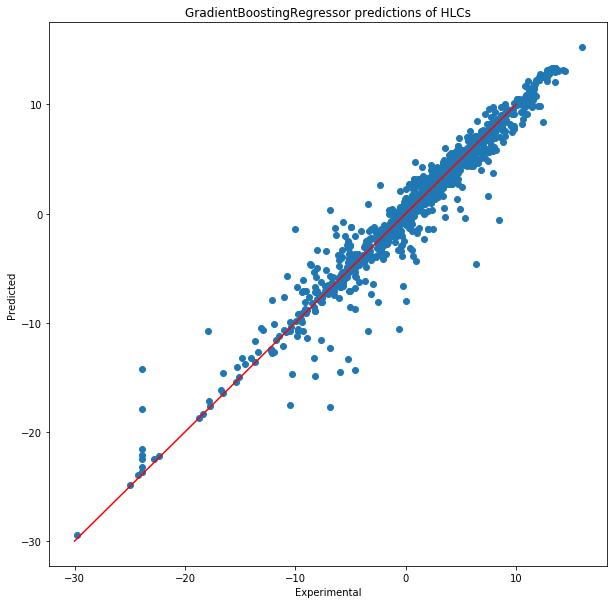

In [70]:
prediction_plot_scores(grad_boost, exp_vs_calc_gbr)

### Kbest + f_reg features

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X[top_15_features_kbest], y, test_size=0.3)

gbr_param_grid = {
    'n_estimators': [500, 1000, 2000],
    'max_depth': [2, 4, 6],
    'min_samples_leaf': [3, 5, 9, 17],
    'learning_rate': [0.1, 0.05, 0.02],
    'max_features': [1.0, 0.3, 0.1],
    'loss': ['ls', 'lad', 'huber']
}

best_hp = grid_search_return_hp_dict(ensemble.GradientBoostingRegressor(), X_train, y_train, gbr_param_grid)
grad_boost = ensemble.GradientBoostingRegressor(**best_hp)
grad_boost.fit(X_train, y_train)

exp_vs_calc_gbr_kbest_freg = produce_exp_vs_pred_df(top_15_features_kbest, grad_boost, "GradBoost, f_reg features")

GradientBoostingRegressor grid search. 


Hyperparameter ranges:
n_estimators 	 [500, 1000, 2000]
max_depth 	 [2, 4, 6]
min_samples_leaf 	 [3, 5, 9, 17]
learning_rate 	 [0.1, 0.05, 0.02]
max_features 	 [1.0, 0.3, 0.1]
loss 	 ['ls', 'lad', 'huber']


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'learning_rate': 0.02, 'loss': 'lad', 'max_depth': 6, 'max_features': 0.3, 'min_samples_leaf': 5, 'n_estimators': 1000}


Training Score:	 0.9441709511875477
Testing Score:	 0.8133849955890944


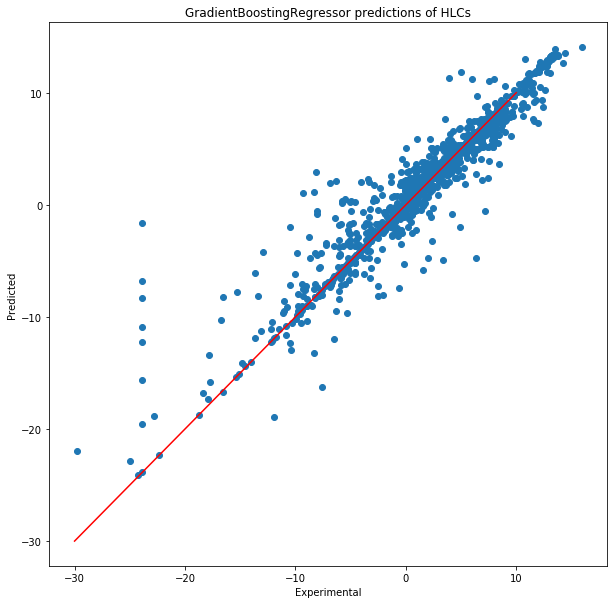

In [72]:
prediction_plot_scores(grad_boost, exp_vs_calc_gbr_kbest_freg)

### K-best using mutual-info scoring function

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X[top_15_features_mutual_info], y, test_size=0.3)

gbr_param_grid = {
    'n_estimators': [500, 1000, 2000],
    'max_depth': [2, 4, 6],
    'min_samples_leaf': [3, 5, 9, 17],
    'learning_rate': [0.1, 0.05, 0.02],
    'max_features': [1.0, 0.3, 0.1],
    'loss': ['ls', 'lad', 'huber']
}

best_hp = grid_search_return_hp_dict(ensemble.GradientBoostingRegressor(), X_train, y_train, gbr_param_grid)

grad_boost_mu = ensemble.GradientBoostingRegressor(**best_hp)
grad_boost_mu.fit(X_train, y_train)

exp_vs_calc_gbr_mu = produce_exp_vs_pred_df(top_15_features_mutual_info, grad_boost_mu, "GradBoost, Mutual Info")

GradientBoostingRegressor grid search. 


Hyperparameter ranges:
n_estimators 	 [500, 1000, 2000]
max_depth 	 [2, 4, 6]
min_samples_leaf 	 [3, 5, 9, 17]
learning_rate 	 [0.1, 0.05, 0.02]
max_features 	 [1.0, 0.3, 0.1]
loss 	 ['ls', 'lad', 'huber']


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'learning_rate': 0.1, 'loss': 'lad', 'max_depth': 6, 'max_features': 1.0, 'min_samples_leaf': 5, 'n_estimators': 1000}


Training Score:	 0.9469806305052978
Testing Score:	 0.8127725335175777


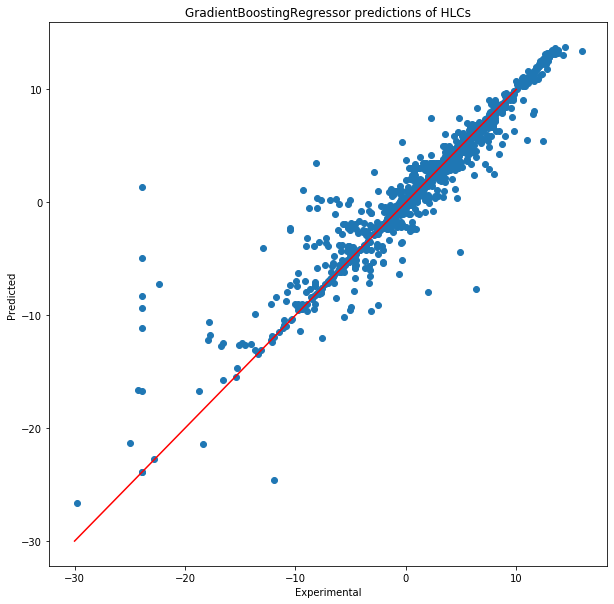

In [74]:
prediction_plot_scores(grad_boost_mu, exp_vs_calc_gbr_mu)

### LASSO dummy model features

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X[top_15_lasso], y, test_size=0.3)

gbr_param_grid = {
    'n_estimators': [500, 1000, 2000],
    'max_depth': [2, 4, 6],
    'min_samples_leaf': [3, 5, 9, 17],
    'learning_rate': [0.1, 0.05, 0.02],
    'max_features': [1.0, 0.3, 0.1],
    'loss': ['ls', 'lad', 'huber']
}

best_hp = grid_search_return_hp_dict(ensemble.GradientBoostingRegressor(), X_train, y_train, gbr_param_grid)

lasso_features_gbr = ensemble.GradientBoostingRegressor(**best_hp)
lasso_features_gbr.fit(X_train, y_train)
exp_vs_calc_lasso_gbr = produce_exp_vs_pred_df(top_15_lasso, lasso_features_gbr, "LASSO-features, GBR model")

GradientBoostingRegressor grid search. 


Hyperparameter ranges:
n_estimators 	 [500, 1000, 2000]
max_depth 	 [2, 4, 6]
min_samples_leaf 	 [3, 5, 9, 17]
learning_rate 	 [0.1, 0.05, 0.02]
max_features 	 [1.0, 0.3, 0.1]
loss 	 ['ls', 'lad', 'huber']


KeyboardInterrupt: 

In [ ]:
prediction_plot_scores(lasso_features_gbr, exp_vs_calc_lasso_gbr)

### Comments on feature selection for gradient boosting
- 'Dummy' model for feature selection gave best test score - 0.84 compared to 0.81 for the SelectKBest methods. Perhaps a grid search should be used for each set of features?

## Decision Tree

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X[top_15_features_model], y, test_size=0.3)

dtr_param_grid = {
    'criterion': ['mse', 'friedman_mse', 'mae'], #function measuring quality of a split
    'max_depth': [5, 10, 20] , # max depth of tree
    'max_features': [5, 10, 15], # N features to be considered when looking for split
    'max_leaf_nodes': [None, 10, 15, 20, 30], #grows tree with N nodes in best-first fashion
    'min_impurity_decrease': [0.0, 0.1],
    'min_samples_leaf': [1, 2, 3], 
    'min_samples_split': [1.0, 2, 3],
    'min_weight_fraction_leaf': [0.0, 0.1, 0.5] , 
    'splitter': ['best', 'random']
}

best_hp = grid_search_return_hp_dict(tree.DecisionTreeRegressor(), X_train, y_train, dtr_param_grid)

dtr = tree.DecisionTreeRegressor(**best_hp)

dtr.fit(X_train, y_train)

exp_vs_calc_dtr = produce_exp_vs_pred_df(top_15_features_model, dtr, "Decision Tree")

DecisionTreeRegressor grid search. 


Hyperparameter ranges:
criterion 	 ['mse', 'friedman_mse', 'mae']
max_depth 	 [5, 10, 20]
max_features 	 [5, 10, 15]
max_leaf_nodes 	 [10, 15, 20, 30]
min_impurity_decrease 	 [0.0, 0.1]
min_samples_leaf 	 [1, 2, 3]
min_samples_split 	 [1.0, 2, 3]
min_weight_fraction_leaf 	 [0.0, 0.1, 0.5]
splitter 	 ['best', 'random']
{'criterion': 'friedman_mse', 'max_depth': 20, 'max_features': 15, 'max_leaf_nodes': 30, 'min_impurity_decrease': 0.1, 'min_samples_leaf': 3, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'splitter': 'random'}


Training Score:	 0.855928166883637
Testing Score:	 0.780099092203602


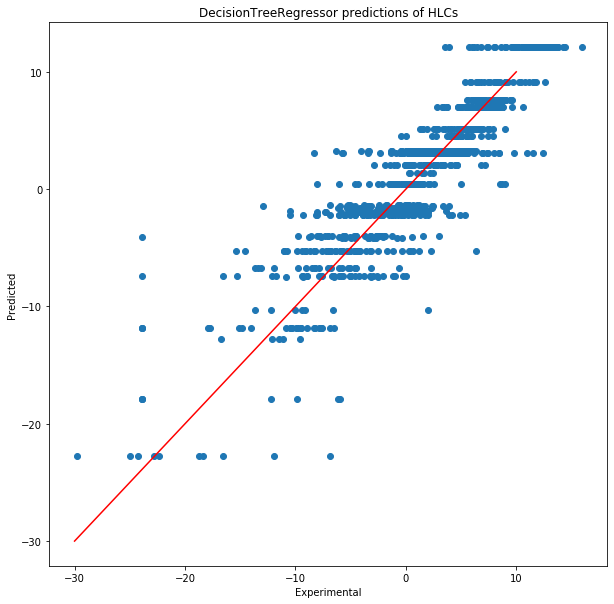

In [105]:
prediction_plot_scores(dtr, exp_vs_calc_dtr)

## AdaBoost Regressor

In [118]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

X_train, X_test, y_train, y_test = train_test_split(X[top_15_features_model], y, test_size=0.3)
# https://stackoverflow.com/questions/51142308/adaboostregressor-with-several-base-estimator
base_models = [ExtraTreesRegressor(n_estimators= 5,
                                   criterion= 'mse',
                                   max_features = 'log2'),
               RandomForestRegressor(n_estimators= 5,
                                     criterion= 'mse',
                                     max_features = 'sqrt',
                                     min_samples_split = 3)]

param_grid = {
    'base_estimator' : base_models, 
    'learning_rate' : [0.3, 0.5, 0.8, 1], 
    'loss' : ['linear', 'square', 'exponential'], 
    'n_estimators' : [50, 100]
}

best_hp = grid_search_return_hp_dict(ensemble.AdaBoostRegressor(), X_train, y_train, param_grid)

ada = ensemble.AdaBoostRegressor(**best_hp)

ada.fit(X_train, y_train)

exp_vs_calc_ada = produce_exp_vs_pred_df(top_15_features_model, ada, "AdaBoost")

AdaBoostRegressor grid search. 


Hyperparameter ranges:


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'base_estimator': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False), 'learning_rate': 0.3, 'loss': 'exponential', 'n_estimators': 50}


Training Score:	 0.9825225866511059
Testing Score:	 0.8780706088702166


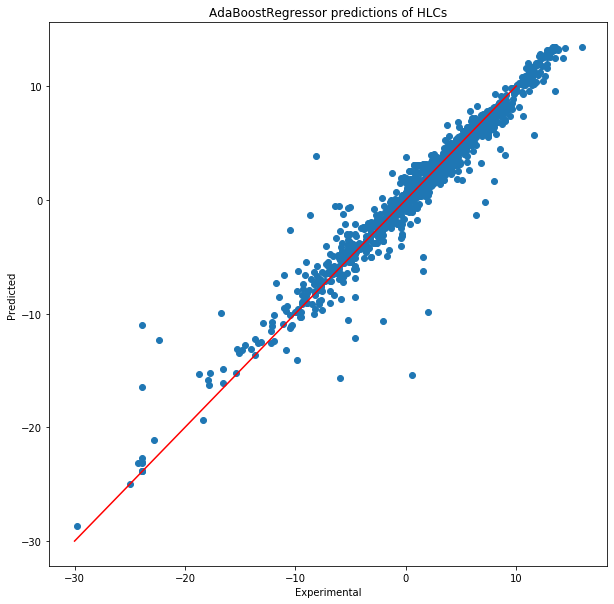

In [120]:
prediction_plot_scores(ada, exp_vs_calc_ada)

## LASSO

In [20]:
lasso = linear_model.Lasso(alpha=0.1, max_iter=10000)
X_train, X_test, y_train, y_test = train_test_split(X[top_15_features_model], y, test_size=0.3)
lasso.fit(X_train, y_train)

exp_vs_calc_lasso = produce_exp_vs_pred_df(top_15_features_model, lasso, "LASSO")

Training Score:	 0.7639514078586844
Testing Score:	 0.7832861569728271


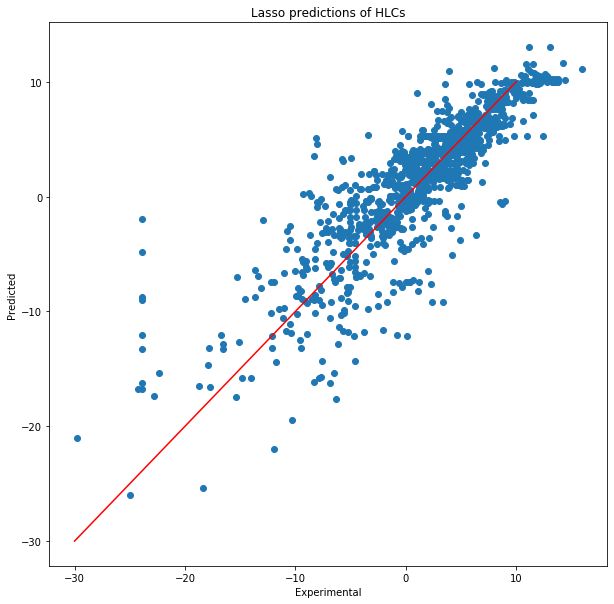

In [21]:
prediction_plot_scores(lasso, exp_vs_calc_lasso)

## Random Forest Regressor
[Look into parameters properly](https://scikit-learn.org/stable/modules/ensemble#random-forest-parameters)

In [26]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor()
X_train, X_test, y_train, y_test = train_test_split(X[top_15_features_model], y, test_size=0.3)
forest.fit(X_train, y_train)
exp_vs_calc_forest = produce_exp_vs_pred_df(top_15_features_model, forest, "RandomForestRegressor")

C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training Score:	 0.9691193367296699
Testing Score:	 0.8227993743051655


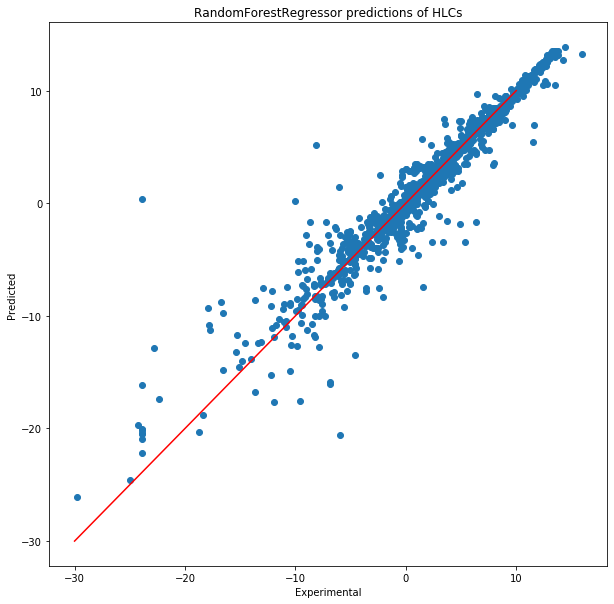

In [27]:
prediction_plot_scores(forest, exp_vs_calc_forest)

# LARS - Least angle regression

In [33]:
from sklearn.linear_model import Lars
X_train, X_test, y_train, y_test = train_test_split(X[top_15_features_model], y, test_size=0.3)
lars = Lars(fit_intercept=False, n_nonzero_coefs=np.inf)
lars.fit(X_train, y_train)
exp_vs_calc_lars = produce_exp_vs_pred_df(top_15_features_model, lars, "LARS")

Training Score:	 0.7547599513398118
Testing Score:	 0.7897284283483548


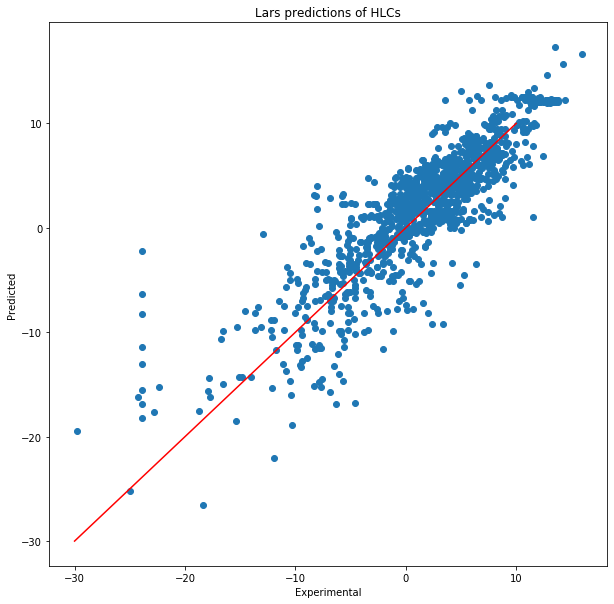

In [34]:
prediction_plot_scores(lars, exp_vs_calc_lars)

## Tensorflow

## PCA

## Scores

In [75]:
display("Training Scores", train_scores, "Testing Scores", test_scores)

exp_vs_calc_df_list = []
for var in dir():
    if isinstance(eval(var), pd.core.frame.DataFrame):
        if var[0:3] == 'exp':
            exp_vs_calc_df_list.append(var)
            
@widgets.interact()

def show_pred_vs_actual(pred_df = exp_vs_calc_df_list):
    fig = plt.figure(figsize=(10, 10))
    scatter = plt.scatter(eval(pred_df)['Experimental'], eval(pred_df)['Predicted'])
    plt.xlabel('Experimental')
    plt.ylabel('Predicted')
    #abels = ['{}'.format(i) for i in species_names]
    #ooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
    #pld3.plugins.connect(fig, tooltip)
    plt.plot([-30, 10], [-30, 10], c='red')
    plt.show()

'Training Scores'

{'GradBoost, model-chosen features': 0.9827071474635066,
 'GradBoost, f_reg features': 0.9441709511875477,
 'GradBoost, Mutual Info': 0.9469806305052978,
 'Decision Tree': 0.8864838077442759,
 'AdaBoost': 0.7651182328337908,
 'LASSO': 0.7639514078586844,
 'RandomForestRegressor': 0.9691193367296699,
 'LARS': 0.7547599513398118}

'Testing Scores'

{'GradBoost, model-chosen features': 0.8676001882884382,
 'GradBoost, f_reg features': 0.8133849955890944,
 'GradBoost, Mutual Info': 0.8127725335175777,
 'Decision Tree': 0.7596298602235639,
 'AdaBoost': 0.6975883457823926,
 'LASSO': 0.7832861569728271,
 'RandomForestRegressor': 0.8227993743051655,
 'LARS': 0.7897284283483548}

interactive(children=(Dropdown(description='pred_df', options=('exp_vs_calc_ada', 'exp_vs_calc_dtr', 'exp_vs_c…